# setup

# [old] PSM v1 - with p-values only


- outcome variables
  - no. PRs
  - no. contributors

- confounding factors
  - no. stars
  - no. forks
  - no. commits
  - no. issues
  - no. PRs (for no. contributors analysis)
  - no. contributors (for no. PRs analysis)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import scipy.stats as stats
from datetime import datetime
import matplotlib.pyplot as plt

In [ ]:
class HackerNewsImpactAnalyzer:
    def __init__(self, treatment_path: str, control_path: str):
        """
        Initialize PSM analyzer with treatment and control datasets

        :param treatment_path: Path to treatment group CSV
        :param control_path: Path to control group CSV
        """
        # Read treatment and control datasets
        self.treatment_df = pd.read_csv(treatment_path)
        self.control_df = pd.read_csv(control_path)

        # Add HN submission flag
        self.treatment_df['hackernews_submitted'] = 1
        self.control_df['hackernews_submitted'] = 0

    def _preprocess_data(self):
        """
        Preprocess data for PSM analysis
        """
        # Calculate repository age (in days)
        def calculate_repo_age(created_at, target_date='2025-01-20'):
            created_at = str(created_at)
            created = datetime.strptime(created_at, '%Y-%m-%dT%H:%M:%SZ')
            target = datetime.strptime(target_date, '%Y-%m-%d')
            return (target - created).days

        # Combine datasets
        combined_df = pd.concat([
            self.treatment_df,
            self.control_df
        ]).reset_index(drop=True)

        # Calculate repository age
        combined_df['repo_age_days'] = combined_df['created_at'].apply(calculate_repo_age)

        return combined_df

    def _calculate_absolute_mean_differences(self, df, treatment_col, covariates):
        """
        Calculate absolute mean differences (or SMD) for covariates
        """
        treatment_group = df[df[treatment_col] == 1]
        control_group = df[df[treatment_col] == 0]

        differences = {}
        for covariate in covariates:
            treatment_mean = treatment_group[covariate].mean()
            control_mean = control_group[covariate].mean()
            treatment_std = treatment_group[covariate].std()
            control_std = control_group[covariate].std()

            # Absolute mean difference
            abs_mean_diff = abs(treatment_mean - control_mean)

            # Standardized mean difference (SMD)
            pooled_std = np.sqrt((treatment_std**2 + control_std**2) / 2)
            smd = abs_mean_diff / pooled_std if pooled_std != 0 else 0

            differences[covariate] = {
                'abs_mean_diff': abs_mean_diff,
                'smd': smd
            }

        return pd.DataFrame(differences).T

    def _plot_covariate_balance(self, before_balance, after_balance, title="Covariate Balance"):
        """
        Plot covariate balance (Love plot)
        """
        # Ensure covariate names (index) are strings
        before_balance.index = before_balance.index.astype(str).fillna('Missing')
        after_balance.index = after_balance.index.astype(str).fillna('Missing')

        plt.figure(figsize=(10, 6))
        plt.scatter(before_balance['smd'], before_balance.index, label='Before Matching', color='red')
        plt.scatter(after_balance['smd'], after_balance.index, label='After Matching', color='blue')
        plt.axvline(x=0.1, color='gray', linestyle='--', label='Threshold (SMD < 0.1)')
        plt.xlabel('Standardized Mean Difference (SMD)')
        plt.ylabel('Covariates')
        plt.title(title)
        plt.legend()
        plt.show()

    def perform_psm_analysis(
        self,
        outcome_variable: str,
        confounding_cols: list = None,
        caliper: float = 0.2
    ):
        """
        Perform Propensity Score Matching analysis

        :param outcome_variable: Variable to analyze (total_prs or pr_contributors)
        :param confounding_cols: Columns to use for propensity score calculation
        :param caliper: Matching tolerance
        :return: Analysis results
        """
        # Default confounding columns if not specified
        # Assumed to be PR growth analysis by default
        if confounding_cols is None:
            confounding_cols = [
                'stars',
                'forks',
                'total_commits',
                'total_issues',
                'total_contributors',
                'repo_age_days'
            ]

        # Preprocess data
        combined_df = self._preprocess_data()

        # Calculate absolute mean differences before matching
        before_balance = self._calculate_absolute_mean_differences(
            combined_df, 'hackernews_submitted', confounding_cols
        )

        # Prepare features for propensity score
        X = combined_df[confounding_cols]

        # Standardize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Calculate propensity scores
        ps_model = LogisticRegression(max_iter=1000)
        ps_model.fit(X_scaled, combined_df['hackernews_submitted'])

        # Add propensity scores
        combined_df['propensity_score'] = ps_model.predict_proba(X_scaled)[:, 1]

        # Separate treatment and control groups
        treatment_group = combined_df[combined_df['hackernews_submitted'] == 1]
        control_group = combined_df[combined_df['hackernews_submitted'] == 0]

        # Matching process
        matched_pairs = []

        # Calculate caliper threshold
        ps_std = np.std(combined_df['propensity_score'])
        caliper_threshold = caliper * ps_std

        for _, treatment_row in treatment_group.iterrows():
            # Find closest control group match within caliper
            control_matches = control_group[
                np.abs(control_group['propensity_score'] - treatment_row['propensity_score'])
                <= caliper_threshold
            ]

            if not control_matches.empty:
                # Select the closest match
                closest_match = control_matches.iloc[
                    np.argmin(
                        np.abs(control_matches['propensity_score'] - treatment_row['propensity_score'])
                    )
                ]

                matched_pairs.append({
                    'treatment': treatment_row,
                    'control': closest_match
                })

        # Convert matched pairs to DataFrame
        matched_df = pd.DataFrame([
            {**pair['treatment'], **{f'control_{k}': v for k, v in pair['control'].items()}}
            for pair in matched_pairs
        ])

        # Calculate absolute mean differences after matching
        after_balance = self._calculate_absolute_mean_differences(
            matched_df, 'hackernews_submitted', confounding_cols
        )

        # Plot covariate balance
        self._plot_covariate_balance(before_balance, after_balance)

        # Statistical analysis
        treatment_outcomes = matched_df[outcome_variable]
        control_outcomes = matched_df[f'control_{outcome_variable}']

        # T-test
        t_statistic, p_value = stats.ttest_ind(
            treatment_outcomes,
            control_outcomes
        )

        # Effect size (Cohen's d)
        cohens_d = (
            np.mean(treatment_outcomes) - np.mean(control_outcomes)
        ) / np.sqrt(
            (np.std(treatment_outcomes)**2 + np.std(control_outcomes)**2) / 2
        )

        # Prepare results
        results = {
            'matched_sample_size': len(matched_pairs),
            'treatment_mean': np.mean(treatment_outcomes),
            'control_mean': np.mean(control_outcomes),
            't_statistic': t_statistic,
            'p_value': p_value,
            'cohens_d': cohens_d,
            'before_balance': before_balance,
            'after_balance': after_balance
        }

        return matched_df, results

    def analyze_pr_growth(self):
        """
        Analyze impact of Hacker News submission on PR growth
        """
        matched_df, results = self.perform_psm_analysis(
            outcome_variable='total_prs'
        )

        print("PR Growth Analysis:")
        print(f"Matched Sample Size: {results['matched_sample_size']}")
        print(f"Treatment Mean PR Growth: {results['treatment_mean']}")
        print(f"Control Mean PR Growth: {results['control_mean']}")
        print(f"T-Statistic: {results['t_statistic']}")
        print(f"P-Value: {results['p_value']}")
        print(f"Cohen's d: {results['cohens_d']}")

        return matched_df, results

    def analyze_contributor_growth(self):
        """
        Analyze impact of Hacker News submission on Contributor growth
        """
        matched_df, results = self.perform_psm_analysis(
            outcome_variable='pr_contributors'
        )

        print("Contributor Growth Analysis:")
        print(f"Matched Sample Size: {results['matched_sample_size']}")
        print(f"Treatment Mean Contributor Growth: {results['treatment_mean']}")
        print(f"Control Mean Contributor Growth: {results['control_mean']}")
        print(f"T-Statistic: {results['t_statistic']}")
        print(f"P-Value: {results['p_value']}")
        print(f"Cohen's d: {results['cohens_d']}")

        return matched_df, results

In [ ]:
TREATMENT_GROUP_PATH = "/content/drive/MyDrive/datasets/muict-naist-senior/rq3/treatment_present/hn_rq3_repos_treatment_v4.csv"
CONTROL_GROUP_PATH = "/content/drive/MyDrive/datasets/muict-naist-senior/rq3/hn_rq3_treatment/hn_rq3_repos_control.csv"

In [ ]:
analyzer = HackerNewsImpactAnalyzer(
    treatment_path=TREATMENT_GROUP_PATH,
    control_path=CONTROL_GROUP_PATH
)


## initial analyses

In [ ]:
pr_growth_results = analyzer.analyze_pr_growth()

ConversionError: Failed to convert value(s) to axis units: masked_array(data=[--, --, --, --, --, --],
             mask=[ True,  True,  True,  True,  True,  True],
       fill_value=1e+20,
            dtype=float64)

<Figure size 1000x600 with 1 Axes>

PR Growth Analysis:
Matched Sample Size: 228
Treatment Mean PR Growth: 52.671052631578945
Control Mean PR Growth: 19.153508771929825
T-Statistic: 4.699339748297085
P-Value: 3.465518229806202e-06
Cohen's d: 0.4411018849005006


P value less than 0.05, therefore significant difference. But negative cohen means that the different is small

In [ ]:
contributor_growth_results = analyzer.analyze_contributor_growth()

Contributor Growth Analysis:
Matched Sample Size: 295
Treatment Mean Contributor Growth: 9.196610169491525
Control Mean Contributor Growth: 8.75593220338983
T-Statistic: 0.7184622758360599
P-Value: 0.47275768312149913
Cohen's d: 0.05925776976522005


Large p-value, difference due to chance

# process control, remove pre-2022 repo

In [33]:
# prompt: read csv from control group file, exclude rows with "created_at" date before 2022 and export as a csv. the column is in this datetime format: 2019-07-29T18:51:24Z

import pandas as pd

# Load the control group data
CONTROL_PATH = "/content/drive/MyDrive/datasets/muict-naist-senior/rq3/control_present/hn_rq3_repos_control_metrics_v1_355.csv"
control_df = pd.read_csv(CONTROL_PATH)

# Convert 'created_at' column to datetime objects
control_df['created_at'] = pd.to_datetime(control_df['created_at'])

# Filter out rows with 'created_at' before 2022
control_df_filtered = control_df[control_df['created_at'].dt.year >= 2022]

# Export the filtered data to a new CSV file
control_df_filtered.to_csv("/content/drive/MyDrive/datasets/muict-naist-senior/rq3/control_present/hn_rq3_repos_control_metrics_v2_2022-2024_355.csv", index=False)

# PSM v3 - PR growth with covariate

In [82]:
CONTROL_OUTPUT_PATH = "/content/drive/MyDrive/datasets/muict-naist-senior/rq3/control_present/hn_rq3_repos_control_metrics_v1_355.csv"
TREATMENT_OUTPUT_PATH = "/content/drive/MyDrive/datasets/muict-naist-senior/rq3/treatment_present/hn_rq3_repos_treatment_v4.csv"

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors


In [84]:
# Load datasets
treatment_df = pd.read_csv(TREATMENT_OUTPUT_PATH)  # Replace with your treatment dataset path
control_df = pd.read_csv(CONTROL_OUTPUT_PATH)      # Replace with your control dataset path

# Add a treatment indicator column
treatment_df['treatment'] = 1
control_df['treatment'] = 0

# Combine datasets
combined_df = pd.concat([treatment_df, control_df], ignore_index=True)

# Define confounding variables (features) and outcome variable
confounders = ['stars', 'total_issues', 'total_contributors', 'total_prs']
outcome = 'total_commits'

# Convert date columns to datetime and calculate project age
combined_df['created_at'] = pd.to_datetime(combined_df['created_at'])
combined_df['last_updated'] = pd.to_datetime(combined_df['last_updated'])
combined_df['project_age'] = (combined_df['last_updated'] - combined_df['created_at']).dt.days

# Drop original date columns and irrelevant columns
combined_df = combined_df.drop(columns=['created_at', 'last_updated', 'repo_url'])


## v1

In [52]:
# Standardize confounding variables
scaler = StandardScaler()
combined_df[confounders] = scaler.fit_transform(combined_df[confounders])

# Fit a logistic regression model to calculate propensity scores
log_reg = LogisticRegression()
log_reg.fit(combined_df[confounders], combined_df['treatment'])
combined_df['propensity_score'] = log_reg.predict_proba(combined_df[confounders])[:, 1]

# Perform Propensity Score Matching using Nearest Neighbors
treatment_scores = combined_df[combined_df['treatment'] == 1]['propensity_score']
control_scores = combined_df[combined_df['treatment'] == 0]['propensity_score']

# Use Nearest Neighbors to find matches
nbrs = NearestNeighbors(n_neighbors=1, metric='euclidean').fit(control_scores.values.reshape(-1, 1))
distances, indices = nbrs.kneighbors(treatment_scores.values.reshape(-1, 1))

# Create matched dataset
matched_control_indices = indices.flatten()
matched_control_df = combined_df[combined_df['treatment'] == 0].iloc[matched_control_indices]
matched_treatment_df = combined_df[combined_df['treatment'] == 1]

matched_df = pd.concat([matched_treatment_df, matched_control_df], ignore_index=True)

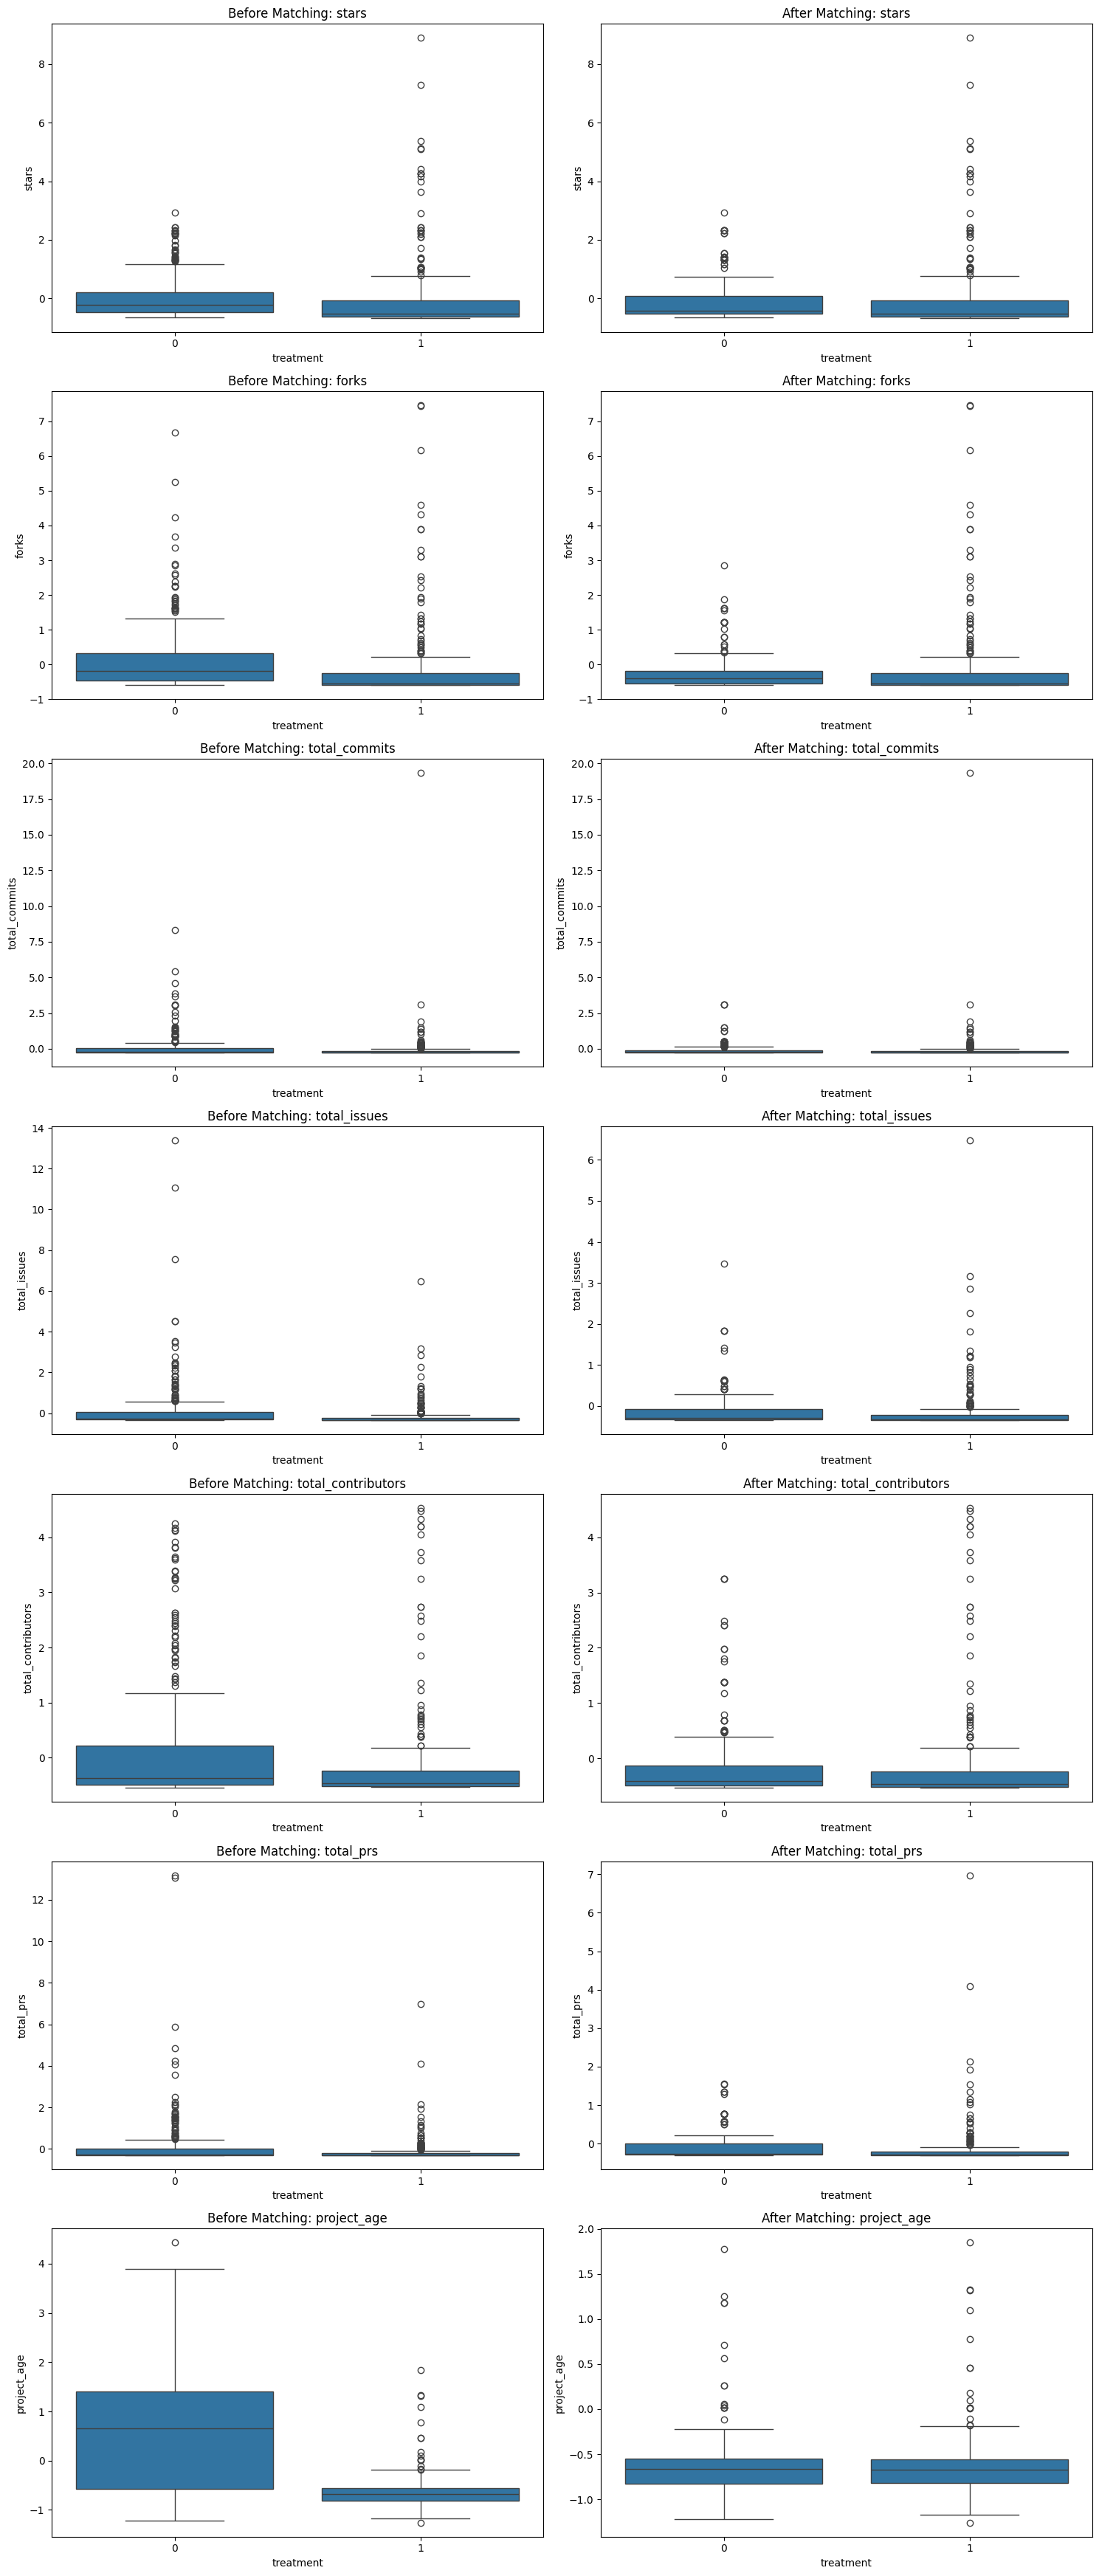

In [ ]:
# Plot covariate balance before and after matching
def plot_covariate_balance(df_before, df_after, confounders):
    fig, axes = plt.subplots(nrows=len(confounders), ncols=2, figsize=(15, 5 * len(confounders)))
    for i, confounder in enumerate(confounders):
        sns.boxplot(x='treatment', y=confounder, data=df_before, ax=axes[i, 0])
        axes[i, 0].set_title(f'Before Matching: {confounder}')
        sns.boxplot(x='treatment', y=confounder, data=df_after, ax=axes[i, 1])
        axes[i, 1].set_title(f'After Matching: {confounder}')
    plt.tight_layout()
    plt.show()

plot_covariate_balance(combined_df, matched_df, confounders)


In [ ]:
# Perform t-test to compare outcome variable (total_prs) between treatment and control groups
from scipy.stats import ttest_ind

treatment_outcome = matched_df[matched_df['treatment'] == 1][outcome]
control_outcome = matched_df[matched_df['treatment'] == 0][outcome]

t_stat, p_value = ttest_ind(treatment_outcome, control_outcome)
print(f"T-statistic: {t_stat}, P-value: {p_value}")


T-statistic: 0.5844303194181536, P-value: 0.5591557549646462


In [ ]:
# Interpret results
if p_value < 0.05:
    print("There is a statistically significant difference in PR growth between treatment and control groups.")
else:
    print("There is no statistically significant difference in PR growth between treatment and control groups.")

There is no statistically significant difference in PR growth between treatment and control groups.


## v2

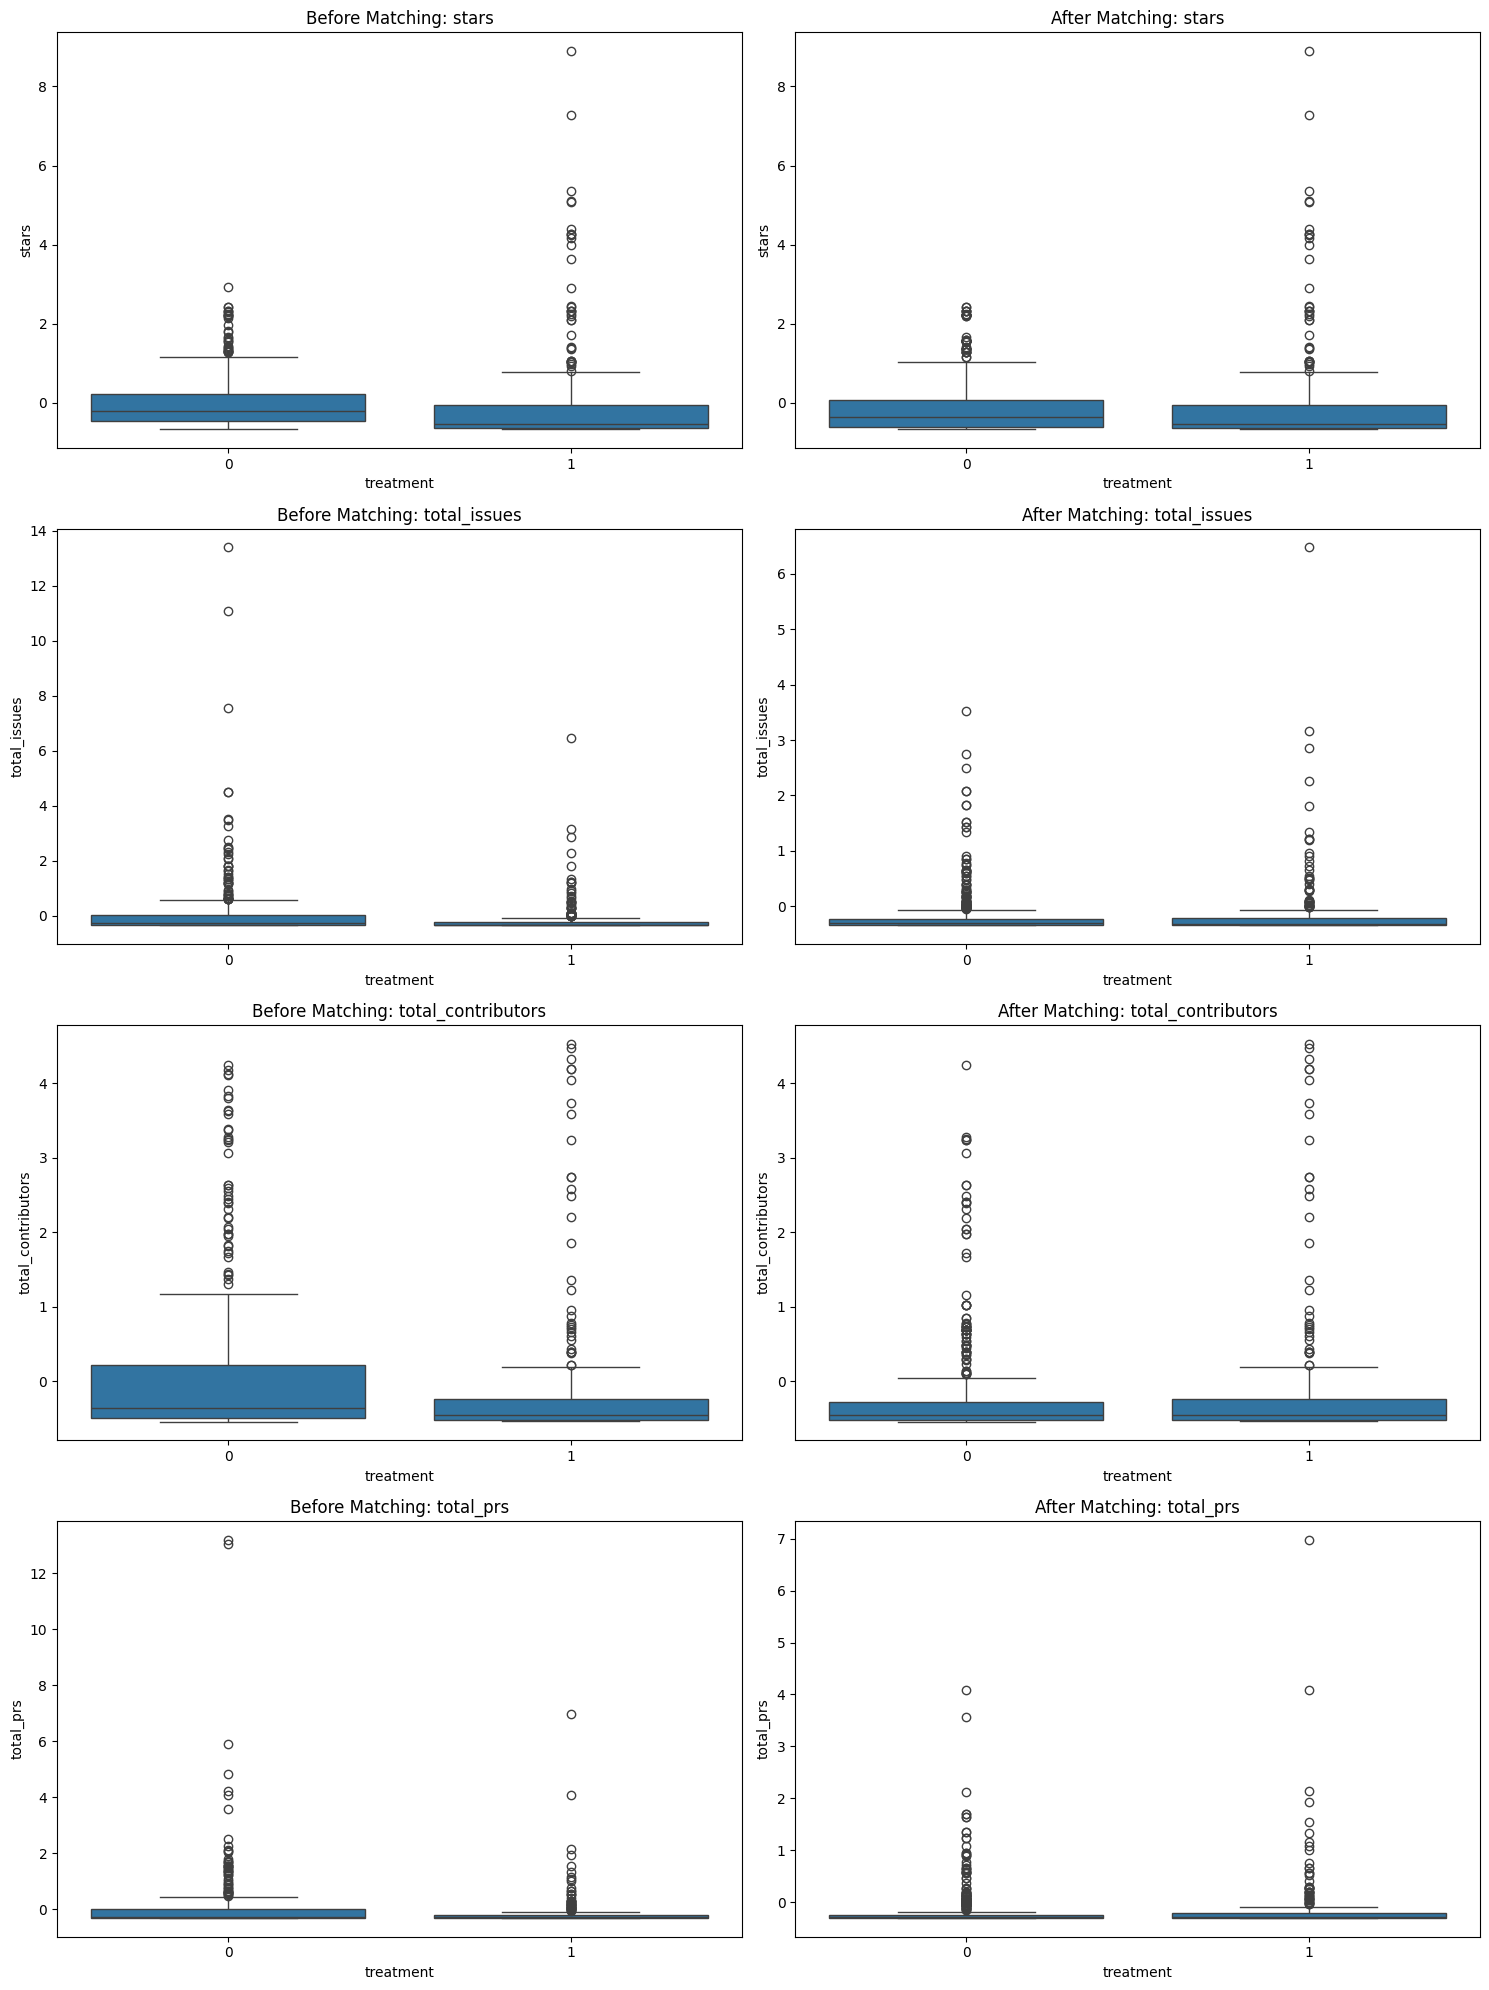

T-statistic: 1.7286845914399747, P-value: 0.08421630601809041


In [85]:
# Standardize confounders
scaler = StandardScaler()
combined_df[confounders] = scaler.fit_transform(combined_df[confounders])

# Fit logistic regression to estimate propensity scores
log_reg = LogisticRegression()
log_reg.fit(combined_df[confounders], combined_df['treatment'])
combined_df['propensity_score'] = log_reg.predict_proba(combined_df[confounders])[:, 1]

# Separate treatment and control groups
treated = combined_df[combined_df['treatment'] == 1]
control = combined_df[combined_df['treatment'] == 0]

# Perform nearest neighbor matching
nbrs = NearestNeighbors(n_neighbors=2, metric='euclidean')
nbrs.fit(control[['propensity_score']])  # Fit on control group's scores
distances, indices = nbrs.kneighbors(treated[['propensity_score']])

# Select matched control observations
matched_control = control.iloc[indices.flatten()].copy()
matched_control['matched'] = True
matched_treated = treated.copy()
matched_treated['matched'] = True

# Create final matched dataset
matched_df = pd.concat([matched_treated, matched_control], ignore_index=True)

# Ensure balance with covariate plot
def plot_covariate_balance(df_before, df_after, confounders):
    fig, axes = plt.subplots(nrows=len(confounders), ncols=2, figsize=(15, 5 * len(confounders)))
    for i, confounder in enumerate(confounders):
        sns.boxplot(x='treatment', y=confounder, data=df_before, ax=axes[i, 0])
        axes[i, 0].set_title(f'Before Matching: {confounder}')
        sns.boxplot(x='treatment', y=confounder, data=df_after, ax=axes[i, 1])
        axes[i, 1].set_title(f'After Matching: {confounder}')
    plt.tight_layout()
    plt.show()

plot_covariate_balance(combined_df, matched_df, confounders)

# Perform t-test on outcome variable (pr_contributors)
treatment_outcome = matched_df[matched_df['treatment'] == 1][outcome]
control_outcome = matched_df[matched_df['treatment'] == 0][outcome]

t_stat, p_value = ttest_ind(treatment_outcome, control_outcome)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

In [86]:
def standardized_mean_diff(df, confounders):
    smd_values = {}
    for confounder in confounders:
        treat_mean = df[df['treatment'] == 1][confounder].mean()
        control_mean = df[df['treatment'] == 0][confounder].mean()
        pooled_std = np.sqrt((df[df['treatment'] == 1][confounder].var() + df[df['treatment'] == 0][confounder].var()) / 2)
        smd = abs(treat_mean - control_mean) / pooled_std
        smd_values[confounder] = smd
    return smd_values

print("Standardized Mean Differences:", standardized_mean_diff(matched_df, confounders))


Standardized Mean Differences: {'stars': 0.11525889566891186, 'total_issues': 0.05661642923401863, 'total_contributors': 0.10958615292149027, 'total_prs': 0.07448546216459527}


In [87]:
from scipy.stats import mannwhitneyu
u_stat, u_p_value = mannwhitneyu(treatment_outcome, control_outcome)
print(f"U-statistic: {u_stat}, P-value: {u_p_value}")


U-statistic: 90761.0, P-value: 0.2253047575448669


# PSM v4 - contrib growth with